In [1]:
import pickle
import warnings
import pandas as pd
import statsmodels.api as sm
import os
import numpy as np
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.stattools import kpss, adfuller
import matplotlib.pyplot as plt
import seaborn as sns

# Changing working directory
os.chdir('/Users/manotas/Documents/GitHub-Repos/CFForecast_Energy_OptionValuation')
plt.rcParams['text.usetex'] = True

# Suppressing specific warnings
warnings.filterwarnings("ignore")

if not os.path.exists('models/'):
    os.makedirs('models')

In [2]:
data = pd.read_csv('data/processed/TopRevenueMNC.csv')

In [3]:
# Reshaping the data to long format
long_data = pd.melt(data, 
                    id_vars=['company', 'industry'], 
                    value_vars=['cash_flow_2023', 'cash_flow_2022', 'cash_flow_2021', 'cash_flow_2020', 'cash_flow_2019'],
                    var_name='year', 
                    value_name='cash_flow')

# Extracting year as an integer
long_data['year'] = long_data['year'].str.extract('(\d+)$').astype(int)

# Sorting by company and year
long_data = long_data.sort_values(by=['company', 'year']).reset_index(drop=True)

In [4]:
# Defining a function to perform KPSS and ADF tests
def test_stationarity(timeseries):
    # KPSS Test
    kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(timeseries, regression='c', nlags="auto")
    print('KPSS Test: Statistic: {}, p-value: {}'.format(kpss_stat, kpss_p))

    # ADF Test
    adf_stat, adf_p, adf_lags, adf_n_obs, adf_crit, adf_icbest = adfuller(timeseries)
    print('ADF Test: Statistic: {}, p-value: {}'.format(adf_stat, adf_p))
    
    return {'kpss_stat': kpss_stat, 'kpss_p_value': kpss_p, 'adf_stat': adf_stat, 'adf_p_value': adf_p}

In [5]:
# Finding the company with the largest cash flow in 2023 for each industry
largest_cash_flow_companies = data.loc[data.groupby('industry')['cash_flow_2023'].idxmax()]

# Applying the tests to the company with the largest cash flow in 2023 for each industry
results = {}

for _, row in largest_cash_flow_companies.iterrows():
    company = row['company']
    industry = row['industry']
    company_data = long_data[long_data['company'] == company]['cash_flow'].dropna()
    
    stationarity_results = test_stationarity(company_data)
    
    results[company] = {
        'industry': industry,
        'kpss_stat': stationarity_results['kpss_stat'],
        'kpss_p_value': stationarity_results['kpss_p_value'],
        'adf_stat': stationarity_results['adf_stat'],
        'adf_p_value': stationarity_results['adf_p_value']
    }

# Converting the results to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')

# Function to add significance stars
def significance_stars(p_value):
    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.1:
        return '*'
    else:
        return ''

# Creating LaTeX table
latex_table = "\\begin{table}[htbp]\n\\centering\n\\begin{tabular}{lllcc}\n\\hline\n"
latex_table += "Company & Industry & ADF Statistic & KPSS Statistic \\\\ \n\\hline\n"

for company, row in results_df.iterrows():
    latex_table += "{} & {} & {:.3f}{} & {:.3f}{} \\\\ \n".format(
        company,
        row['industry'],
        row['adf_stat'], significance_stars(row['adf_p_value']),
        row['kpss_stat'], significance_stars(row['kpss_p_value'])
    )

latex_table += "\\hline\n\\end{tabular}\n"
latex_table += "\\caption{Stationarity test results for companies with the largest cash flow in 2023 per industry.}\n"
latex_table += "\\label{tab:stationarity}\n"
latex_table += "\\end{table}\n"
latex_table += "Note: *p<0.1; **p<0.05; ***p<0.01\n"

print(latex_table)

KPSS Test: Statistic: 0.28452169987803766, p-value: 0.1
ADF Test: Statistic: -1.1361380127803105, p-value: 0.7004475097748875
KPSS Test: Statistic: 0.5000000000000003, p-value: 0.041666666666666595
ADF Test: Statistic: -4.170318494659155, p-value: 0.000739416322923178
KPSS Test: Statistic: 0.30861021333535843, p-value: 0.1
ADF Test: Statistic: -0.2511554927709788, p-value: 0.9321429405978974
\begin{table}[htbp]
\centering
\begin{tabular}{lllcc}
\hline
Company & Industry & ADF Statistic & KPSS Statistic \\ 
\hline
SHELL PLC & Crude_Oil & -1.136 & 0.285 \\ 
ELECTRICITE DE FRANCE & Electricity & -4.170*** & 0.500** \\ 
SOCIETATEA NATIONALA DE GAZE NATURALE ROMGAZ S.A. & Natural_Gas & -0.251 & 0.309 \\ 
\hline
\end{tabular}
\caption{Stationarity test results for companies with the largest cash flow in 2023 per industry.}
\label{tab:stationarity}
\end{table}
Note: *p<0.1; **p<0.05; ***p<0.01



In [6]:
# Apply the tests to each company's cash flow data
for company in long_data['company'].unique():
    company_data = long_data[long_data['company'] == company]['cash_flow'].dropna()
    print(f"\nStationarity test results for {company}:")
    test_stationarity(company_data)


Stationarity test results for A2A S.P.A.:
KPSS Test: Statistic: 0.39031179725349485, p-value: 0.0813311218734936
ADF Test: Statistic: -0.6290719644168573, p-value: 0.8642767251645413

Stationarity test results for AB IGNITIS GROUP:
KPSS Test: Statistic: 0.47584832983127184, p-value: 0.047106232019983825
ADF Test: Statistic: -1.0836383746147513, p-value: 0.7215524344762367

Stationarity test results for ACEA SPA:
KPSS Test: Statistic: 0.16317819922189955, p-value: 0.1
ADF Test: Statistic: -1.234347446646336, p-value: 0.6586486000143081

Stationarity test results for AKER BP ASA:
KPSS Test: Statistic: 0.3486771815486369, p-value: 0.09927707691869098
ADF Test: Statistic: -0.38158617020269847, p-value: 0.9131281280037816

Stationarity test results for AKTSIONERNOE OBSCHESTVO KOMI ENERGOSBYTOVAYA KOMPANIYA:
KPSS Test: Statistic: 0.33922904357596384, p-value: 0.1
ADF Test: Statistic: -0.5538734246907239, p-value: 0.8810678893978943

Stationarity test results for AKTSIONERNOE OBSCHESTVO ULYA

ARIMA(1,1,0) Model for SHELL PLC:
                               SARIMAX Results                                
Dep. Variable:              cash_flow   No. Observations:                    5
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -43.162
Date:                Wed, 03 Jul 2024   AIC                             90.324
Time:                        05:39:32   BIC                             89.097
Sample:                             0   HQIC                            87.631
                                  - 5                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2877      0.491     -0.585      0.558      -1.251       0.676
sigma2      1.762e+08   8.01e-10    2.2e+17      0.000    1.76e+08    1.76e+08
Ljung-Box (L1) (Q)

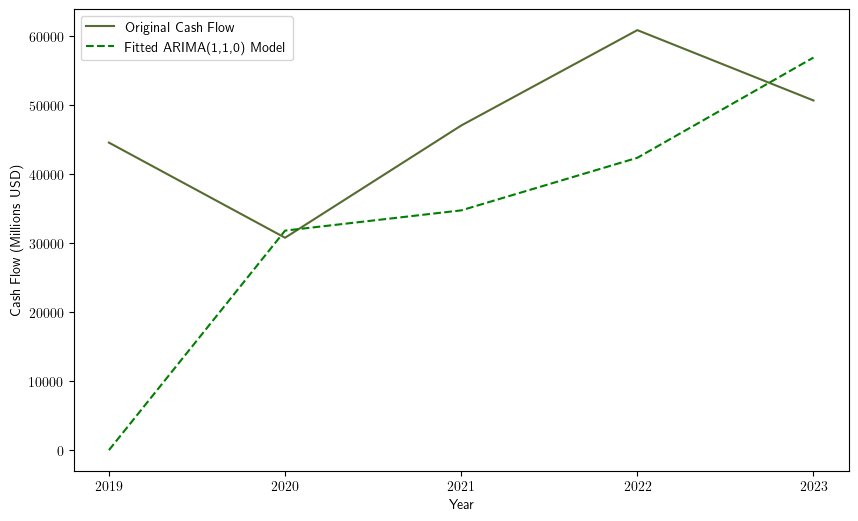

ARIMA(1,1,0) Model for ELECTRICITE DE FRANCE:
                               SARIMAX Results                                
Dep. Variable:              cash_flow   No. Observations:                    5
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -44.377
Date:                Wed, 03 Jul 2024   AIC                             92.754
Time:                        05:39:33   BIC                             91.526
Sample:                             0   HQIC                            90.060
                                  - 5                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000      0.446     -2.243      0.025      -1.874      -0.126
sigma2      2.391e+08   2.37e-10   1.01e+18      0.000    2.39e+08    2.39e+08
Ljung-

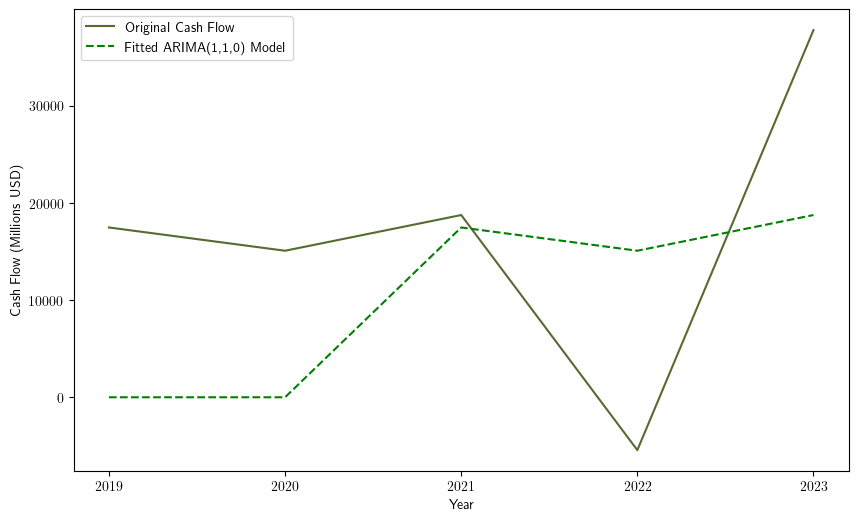

ARIMA(1,1,0) Model for SOCIETATEA NATIONALA DE GAZE NATURALE ROMGAZ S.A.:
                               SARIMAX Results                                
Dep. Variable:              cash_flow   No. Observations:                    5
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -23.496
Date:                Wed, 03 Jul 2024   AIC                             50.991
Time:                        05:39:33   BIC                             49.764
Sample:                             0   HQIC                            48.298
                                  - 5                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0929      2.492      0.037      0.970      -4.790       4.976
sigma2      7372.0755   5.65e+04      0.130      0.896   

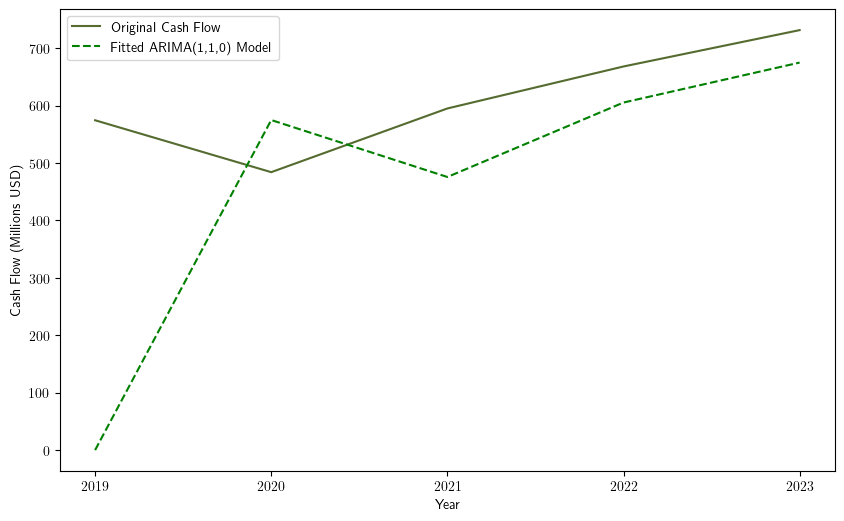

In [7]:
# Dictionary to store the ARIMA models
arima_models = {}

# Fit ARIMA(1,1,0) model for each company
for company in largest_cash_flow_companies['company']:
    company_data = long_data[long_data['company'] == company].set_index('year')['cash_flow'].dropna()
    if company_data.shape[0] > 1:  # Ensure there are enough data points
        model = sm.tsa.ARIMA(company_data, order=(1, 1, 0)).fit()
        arima_models[company] = model

# Display summary and plot for each company
for company, model in arima_models.items():
    # Display summary
    print(f"ARIMA(1,1,0) Model for {company}:")
    print(model.summary())
    
    # Plot the original and fitted values
    company_data = long_data[long_data['company'] == company].set_index('year')['cash_flow'].dropna()
    fitted_values = arima_models[company].fittedvalues

    plt.figure(figsize=(10, 6))
    plt.plot(company_data.index, company_data, label='Original Cash Flow', color='darkolivegreen')
    plt.plot(company_data.index, fitted_values, label='Fitted ARIMA(1,1,0) Model', linestyle='--', color='green')
    plt.xlabel('Year')
    plt.ylabel('Cash Flow (Millions USD)')
    plt.xticks(company_data.index.astype(int))
    plt.legend()
    plt.savefig(f'reports/images/{company}_arima.pdf', dpi=320)
    plt.show()


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(y_actual, predictions):
    '''
    A function that calculates and prints the RMSE, MAE, sMAPE and R2 score of a given actual and predicted series.
    A caveat of sMAPE, we measure it as outlined by Makridakis and Hibon (2000). Further information can be found in:
    https://robjhyndman.com/hyndsight/smape/. As well as both sources defined in the references folder.
    '''
    # Calculate Mean Squared Error and Root Mean Squared Error
    mse = mean_squared_error(y_actual, predictions)
    rmse = np.sqrt(mse)
    
    # Calculate Mean Absolute Error
    mae = mean_absolute_error(y_actual, predictions)
    
    # Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
    smape = np.mean(2.0 * np.abs(y_actual - predictions) / ((np.abs(y_actual) + np.abs(predictions)) + 1e-10)) * 100
    
    # Calculate R-squared
    r2 = r2_score(y_actual, predictions)

    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'sMAPE(0-200): {smape}%')
    print(f'R-squared: {r2}')

In [9]:
# Fit ARIMA(1,1,0) model for each company and calculate metrics
arima_models = {}
all_actuals = []
all_predictions = []

for company in long_data['company'].unique():
    company_data = long_data[long_data['company'] == company].set_index('year')['cash_flow'].dropna()
    if company_data.shape[0] > 1:  # Ensure there are enough data points
        model = sm.tsa.ARIMA(company_data, order=(1, 1, 0)).fit()
        arima_models[company] = model
        
        # Get predictions
        predictions = model.fittedvalues
        
        # Store actual and predicted values
        all_actuals.extend(company_data)
        all_predictions.extend(predictions)

# Calculate overall metrics
print("Overall Metrics:")
calculate_metrics(np.array(all_actuals), np.array(all_predictions))

Overall Metrics:
RMSE: 3181.885608241803
MAE: 759.5312491168565
sMAPE(0-200): 80.50523142993501%
R-squared: 0.7056627864315972


In [10]:
# Storing the fitted models
with open('/Users/manotas/Documents/GitHub-Repos/CFForecast_Energy_OptionValuation/models/ARIMA_models.pkl', 'wb') as f:
    pickle.dump(arima_models, f)